The following variables control which aspect of the data we want to analyze; either "accuracy", "time", or "effort". 

In [85]:
analysis_type = "effort"
aggregation = "mean"

tasks = ["T1", "T2", 'T3', "T4", "T5", "T6"]

Necessary packages

In [86]:
import pandas as pd 
import numpy as np 
import pylab as plt
import json 

Load in the data and set up some formatting

In [87]:
with open("CHI-format.json", 'r') as fdata:
    data = json.load(fdata)
data[0]["E"]['e']["T1"]
data = [d for i,d in enumerate(data) if i != 28]

In [88]:
def compute_aggregation(values):
    if not values: return None
    if aggregation == "mean":
        return sum(values) / len(values)
    elif aggregation == "median":
        from statistics import median
        return median(values)
    
def flatten(nested):
    return [x for xs in nested for x in xs]

Data format: 
```
[
    {
        'E': {
            'e': {
                'T1': {
                    'accuracy': [0,1,0],
                    'time': [2.3, 2.7, 4.91],
                    'effort': [3, 5, 9]
                }, 
                ...
            }, 
            ...
        }, 
        ...
    }, 
    ...
]
```
Each entry is a participant, their responses partitioned by geometry, graph type, and task type. 

In [89]:
factors = list()
for i,participant in enumerate(data):
    for geom in 'EHS':
        for gtype in 'ehs':
            aggregatelist = flatten([participant[geom][gtype][t][analysis_type] for t in tasks])
            factors.append([compute_aggregation(aggregatelist), f'p_{i}', f'{gtype}_{geom}'])

h1 = pd.DataFrame([factor for factor in factors if 'e_' in factor[2]], columns=["values", 'participants', "groups"])
h1.to_csv(f"CHI-hypotheses/H1a-{analysis_type}.csv", index=False)
h2 = pd.DataFrame([factor for factor in factors if 'h_' in factor[2]], columns=["values", 'participants', "groups"])
h2.to_csv(f"CHI-hypotheses/H1b-{analysis_type}.csv", index=False)
h3 = pd.DataFrame([factor for factor in factors if 's_' in factor[2]], columns=["values", 'participants', "groups"])
h3.to_csv(f"CHI-hypotheses/H1c-{analysis_type}.csv", index=False)

In [90]:
results = dict()
for geom in "EHS":
    for gtype in 'ehs':
        # results[f'{gtype}({geom})'] = [compute_aggregation(p[geom][gtype][t][analysis_type]) for p in data for t in tasks]
        intermediate = list()
        for p in data:
            tmp = [p[geom][gtype][t][analysis_type] for t in tasks if p[geom][gtype][t][analysis_type]]
            tmp = flatten(tmp)
            intermediate.append(compute_aggregation(tmp))
        results[f'{gtype}({geom})'] = intermediate
        # results[f'{gtype}({geom})'] = [p for p in results[f'{gtype}({geom})'] if p]
        # print(results[f'{gtype}({geom})'])

In [91]:
results['e(E)'][:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [92]:
df = pd.DataFrame(results)

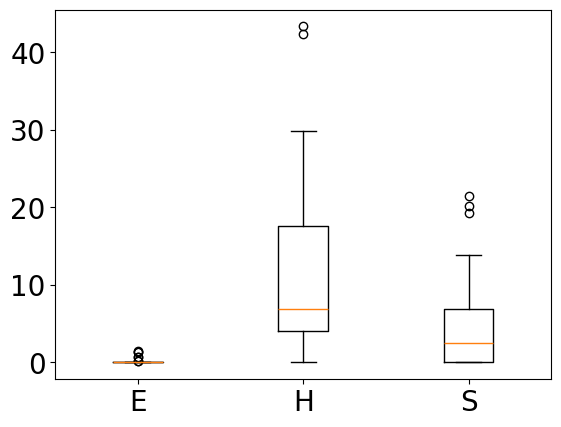

In [93]:
plt.boxplot(df[['e(E)', 'e(H)', 'e(S)']].to_numpy(), labels=["E", "H", "S"])
# plt.suptitle(f"H1a with {analysisType}")
# plt.savefig(f"hypotheses/H1a_{analysisType}.png")
plt.show()


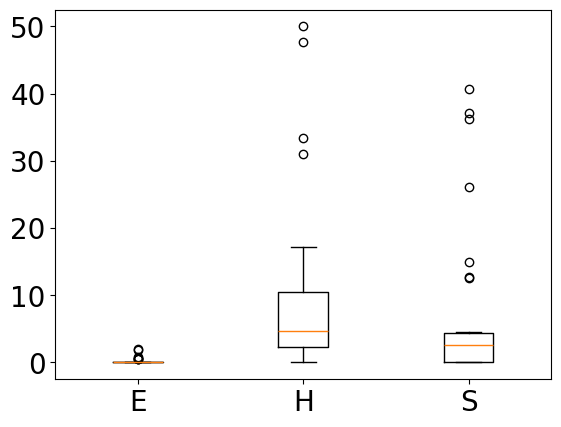

In [94]:
plt.boxplot(df[['h(E)', 'h(H)', 'h(S)']].to_numpy(), labels=["E", "H", "S"])

plt.show()

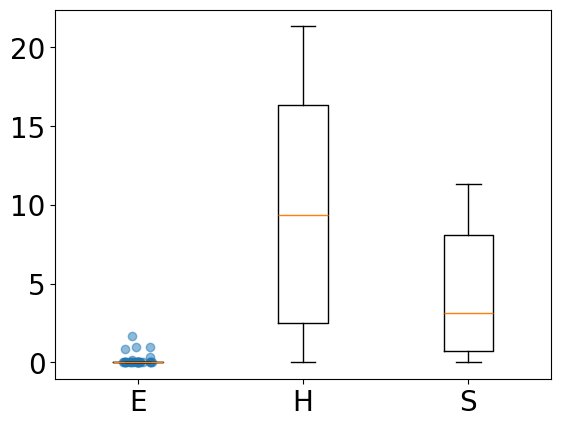

In [95]:
scatter_data = df['s(E)'].to_numpy()
plt.scatter(np.random.uniform(0.9,1.1,size=len(scatter_data)), scatter_data,alpha=0.5)

plt.boxplot(df[['s(E)', 's(H)', 's(S)']].to_numpy(), labels=["E", "H", "S"],showfliers=False)

plt.show()

In [96]:
import scipy.stats as st


In [97]:
labels = list()
means = list()
for gtype in "ehs":
    for geom in "EHS":
        lab = f"{gtype}({geom})"
        labels.append(lab)
        mean = compute_aggregation(results[lab])
        CI = st.t.interval(confidence=0.95, df=len(results[lab])-1, loc=mean, scale=st.sem(results[lab]))
        means.append( (mean, CI[0], CI[1], results[lab]) )
means = means[::-1]
labels = labels[::-1]

In [98]:
labels

['s(S)', 's(H)', 's(E)', 'h(S)', 'h(H)', 'h(E)', 'e(S)', 'e(H)', 'e(E)']

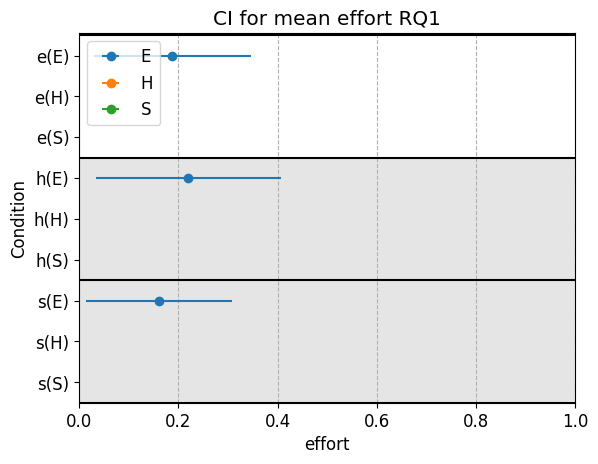

In [99]:
plt.rcParams.update({'font.size': 12})


colors = ["tab:blue", "tab:orange", "tab:green"][::-1]
fig, ax = plt.subplots()
error_plots = list()
for i,(mean, low, high,values) in enumerate(means):
    y = i/10 
    sd = 1 / 30
    scaterY = np.random.uniform(y-sd, y + sd,size=len(values))
    # ax.scatter(values, scaterY,c=colors[i%3],alpha=0.2)
    err = ax.errorbar(mean, [i/10], xerr=[abs(high - mean)], fmt='o',color=colors[i%3])
    error_plots.append(err)
    

xmin = 0.0
xmax = max(means, key=lambda x: x[2])[2] + 0.5
ax.set_xlim(xmin, xmax)
ax.set_xlim(0,1)
ax.legend(error_plots[:3:-1],["E", "H", "S"],loc="upper left")

ax.set_yticks([i / 10 for i in range(9)], labels=labels)
ax.set_ylim(-0.05, 8/10 + 0.055)
ax.hlines([0-0.05, 0.25, (5/10 + 0.05), 8/10 + 0.05], xmin, xmax, colors="black")
ax.grid(True,axis='x',linestyle='--')

ax.axhspan(-0.05,0.25,facecolor="grey",alpha=0.2)
ax.axhspan(0.25, 0.55,facecolor="grey",alpha=0.2)
# ax.axhspan(0.55,0.85, facecolor='grey', alpha=0.2)


ax.set_xlabel(analysis_type)
ax.set_ylabel("Condition")
ax.set_title(f"CI for {aggregation} {analysis_type} RQ1")

# ax2 = ax.twinx()
# ax2.set_ylim(-0.05, 8/10 + 0.055)
# ax2.set_yticks([i / 10 for i in range(1,9,3)], ["H1c", "H1b", "H1a"])

# fig.set_size_inches(10,5)
fig.savefig(f"figures/RQ1vis_{analysis_type}.pdf")

In [100]:
df.head()

,e(E),h(E),s(E),e(H),h(H),s(H),e(S),h(S),s(S)
0,0.0,0.0,0.000000,5.666667,0.500000,1.500000,1.500000,0.000000,2.333333
1,0.0,0.0,0.000000,8.000000,4.000000,9.333333,0.166667,4.500000,4.500000
2,0.0,0.5,1.000000,15.500000,16.000000,3.833333,0.500000,0.833333,3.000000
3,0.0,0.0,0.166667,4.166667,2.166667,2.333333,0.000000,0.000000,1.666667
4,0.0,0.0,0.000000,4.000000,3.833333,14.000000,1.166667,0.666667,4.500000


In [101]:
full_factors = pd.concat((h1,h2,h3),ignore_index=True)

In [102]:
import ptitprince as pt

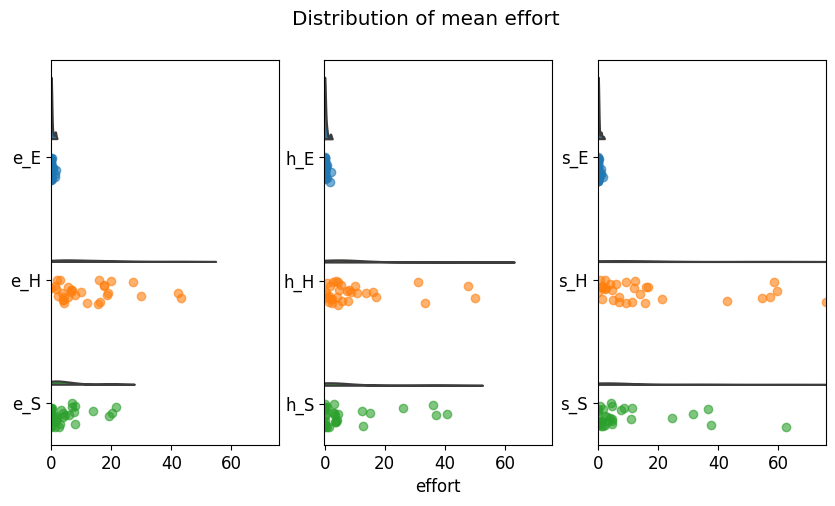

In [103]:
fig,axes = plt.subplots(1,3)

pt.half_violinplot(x='values',y='groups',data=h1,inner=None,width=1,ax=axes[0])
pt.half_violinplot(x='values',y='groups',data=h2,inner=None,width=1,ax=axes[1])
pt.half_violinplot(x='values',y='groups',data=h3,inner=None,width=1,ax=axes[2])

groups = ['e_E', 'e_H', 'e_S', 'h_E', 'h_H', 'h_S', 's_E', 's_H', 's_S']

minx = np.min(full_factors['values'])
maxx = np.max(full_factors['values'])
for i, group in enumerate(groups):
    data = full_factors[full_factors['groups'] == group]
    y = (i%3) + np.random.uniform(high=0.2, size=len(data))
    x = data['values']

    ax = axes[i // 3]

    ax.set_xlim(minx-0.1,maxx+0.1)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x,y,alpha=0.6)

axes[1].set_xlabel(analysis_type)
fig.suptitle(f"Distribution of {aggregation} {analysis_type}")
fig.set_size_inches(10,5)
fig.savefig(f"figures/RQ1_{analysis_type}_raincloud.pdf")

In [104]:
H = pd.concat([h1,h2,h3])
H.head()

,values,participants,groups
0,0.000000,p_0,e_E
1,5.666667,p_0,e_H
2,1.500000,p_0,e_S
3,0.000000,p_1,e_E
4,8.000000,p_1,e_H


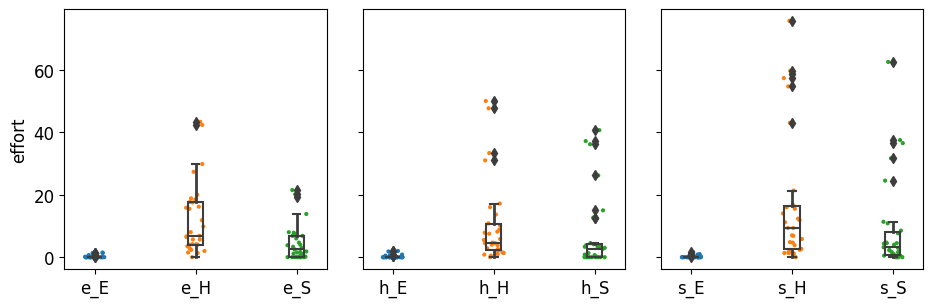

In [105]:
fig, axes = plt.subplots(1,3,sharey=True)
for i,(ax,h) in enumerate(zip(axes, [h1,h2,h3])):
   
    # ax.set_aspect("equal", adjustable='box')

    # fig, ax = plt.subplots()
    pt.RainCloud(x='groups',y='values',data=h,bw=0.2,cut=0,orient='v',ax=ax,palette="tab10")
    # ax.set_yticks([])
    ax.get_children()[0].remove()
    ax.get_children()[0].remove()
    ax.get_children()[0].remove()

    # fig.tight_layout()

    ax.set_xlim(-0.3,2.3)
    # ax.set_ylim(0,80)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if i == 0:
        ax.set_ylabel(analysis_type)
    # else: ax.set_yticks([])
    
    
    # ax = pt.RainCloud(x='groups',y='values',data=H,bw=0.2,cut=0,orient='v')
    # fig.set_size_inches(5,5)
    # fig.savefig(f"figures/new_boxplots_RQ1_{analysis_type}_{i}.pdf",bbox_inches="tight")
fig.tight_layout()
# plt.subplots_adjust(
#     left=0.4,
#     right=0.9,
#     bottom=0.1,
#     top=0.8,
#     wspace=0.2,
#     hspace=0.2
# )
fig.set_size_inches(10,3)
fig.savefig("figures/RQ1_time_test.pdf")

In [106]:
axes[0].get_children().pop(0)

In [107]:
groups = ['e(E)', 'e(H)', 'e(S)', 'h(E)', 'h(H)', 'h(S)', 's(E)', 's(H)', 's(S)']

wilcox = dict()
for g1 in groups:
    wilcox[g1] = dict()
    for g2 in groups: 
        if g1 == g2:
            wilcox[g1][g2] = 0
            continue
        x = df[g1].to_numpy()
        y = df[g2].to_numpy()
        wilcox[g1][g2] = st.wilcoxon(x,y)[1]

wilcoxdf = pd.DataFrame(wilcox)


In [108]:
wilcoxdf

,e(E),e(H),e(S),h(E),h(H),h(S),s(E),s(H),s(S)
e(E),0.000000,0.000002,0.000039,0.624492,0.000002,0.000063,0.798346,0.000002,0.000008
e(H),0.000002,0.000000,0.000045,0.000002,0.220997,0.001588,0.000002,0.802199,0.008466
e(S),0.000039,0.000045,0.000000,0.000035,0.014377,0.423687,0.000032,0.000075,0.035162
h(E),0.624492,0.000002,0.000035,0.000000,0.000002,0.000063,0.414520,0.000002,0.000008
h(H),0.000002,0.220997,0.014377,0.000002,0.000000,0.039356,0.000002,0.068677,0.117968
h(S),0.000063,0.001588,0.423687,0.000063,0.039356,0.000000,0.000067,0.000287,0.487280
s(E),0.798346,0.000002,0.000032,0.414520,0.000002,0.000067,0.000000,0.000002,0.000008
s(H),0.000002,0.802199,0.000075,0.000002,0.068677,0.000287,0.000002,0.000000,0.000258
s(S),0.000008,0.008466,0.035162,0.000008,0.117968,0.487280,0.000008,0.000258,0.000000


In [109]:
df.head()

,e(E),h(E),s(E),e(H),h(H),s(H),e(S),h(S),s(S)
0,0.0,0.0,0.000000,5.666667,0.500000,1.500000,1.500000,0.000000,2.333333
1,0.0,0.0,0.000000,8.000000,4.000000,9.333333,0.166667,4.500000,4.500000
2,0.0,0.5,1.000000,15.500000,16.000000,3.833333,0.500000,0.833333,3.000000
3,0.0,0.0,0.166667,4.166667,2.166667,2.333333,0.000000,0.000000,1.666667
4,0.0,0.0,0.000000,4.000000,3.833333,14.000000,1.166667,0.666667,4.500000


31
[<matplotlib.lines.Line2D object at 0x7ad2592e57c0>, <matplotlib.lines.Line2D object at 0x7ad2592e6090>, <matplotlib.lines.Line2D object at 0x7ad25ab50bc0>]
31
[<matplotlib.lines.Line2D object at 0x7ad2592c8440>, <matplotlib.lines.Line2D object at 0x7ad2592cac60>, <matplotlib.lines.Line2D object at 0x7ad25938bbc0>]
31
[<matplotlib.lines.Line2D object at 0x7ad2597821b0>, <matplotlib.lines.Line2D object at 0x7ad259300bc0>, <matplotlib.lines.Line2D object at 0x7ad259301820>]


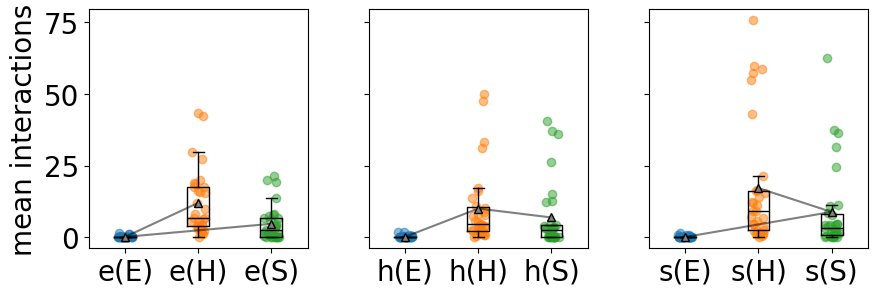

In [111]:
groups = [
    ['e(E)','e(H)','e(S)'],
    ['h(E)','h(H)','h(S)'],
    ['s(E)','s(H)','s(S)']
]

plt.rcParams.update({'font.size': 20})

fig,axes = plt.subplots(1,3,sharey=True)
fig.set_dpi(100)
for ax, (v1,v2,v3) in zip(axes,groups):
    offsets = [1,2,3]
    ax.scatter(np.random.uniform(offsets[0]-0.1, offsets[0]+0.1,size=len(results[v1])), results[v1],alpha=0.5)
    ax.scatter(np.random.uniform(offsets[1]-0.1, offsets[1]+0.1,size=len(results[v1])), results[v2],alpha=0.5)
    ax.scatter(np.random.uniform(offsets[2]-0.1, offsets[2]+0.1,size=len(results[v1])), results[v3],alpha=0.5)

    print(len(results[v1]))

    D = np.array([results[v1], results[v2], results[v3]]).T
    boxplot = ax.boxplot(D, labels=[v1,v2,v3],showfliers=False,medianprops={"color": "black"},showmeans=True,meanprops={"markerfacecolor":"grey", 'markeredgecolor': "black"})
    print(boxplot['means'])
    if ax == axes[0]:
        bmeans = boxplot['means']
        p1 = bmeans[0]
        p2 = bmeans[1]
        p3 = bmeans[2]
        ax.plot([p1.get_xdata(), p2.get_xdata()], [p1.get_ydata(), p2.get_ydata()], alpha=0.5,color='black') 
        ax.plot([p1.get_xdata(), p3.get_xdata()], [p1.get_ydata(), p3.get_ydata()], alpha=0.5,color='black') 

    if ax == axes[1]:
        bmeans = boxplot['means']
        p1 = bmeans[1]
        p2 = bmeans[0]
        p3 = bmeans[2]
        ax.plot([p1.get_xdata(), p2.get_xdata()], [p1.get_ydata(), p2.get_ydata()], alpha=0.5,color='black') 
        ax.plot([p1.get_xdata(), p3.get_xdata()], [p1.get_ydata(), p3.get_ydata()], alpha=0.5,color='black') 

    if ax == axes[2]:
        bmeans = boxplot['means']
        p1 = bmeans[2]
        p2 = bmeans[1]
        p3 = bmeans[0]
        ax.plot([p1.get_xdata(), p2.get_xdata()], [p1.get_ydata(), p2.get_ydata()], alpha=0.5,color='black') 
        ax.plot([p1.get_xdata(), p3.get_xdata()], [p1.get_ydata(), p3.get_ydata()], alpha=0.5,color='black')         


# scatter_data = df['s(E)'].to_numpy()
# plt.scatter(np.random.uniform(0.9,1.1,size=len(scatter_data)), scatter_data,alpha=0.5)

# plt.boxplot(df[['s(E)', 's(H)', 's(S)']].to_numpy(), labels=["E", "H", "S"],showfliers=False)

# plt.show()

axes[0].set_ylabel(f'{aggregation} {analysis_type if analysis_type != "effort" else 'interactions'}')
fig.tight_layout()
fig.set_size_inches(10,3)
fig.savefig(f"figures/CHI_RQ1_{analysis_type}.pdf",bbox_inches='tight')